In [ ]:

from google.colab import drive
drive.mount('/content/drive')+
import os
DATASET_PATH = '/content/drive/MyDrive/Colab_Projects/Final Dataset'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab_Projects/deepfake_model_advanced.keras'
print(" Paths set successfully!")
print("Dataset Path:", DATASET_PATH)
print("Model Save Path:", MODEL_SAVE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Paths set successfully!
Dataset Path: /content/drive/MyDrive/Colab_Projects/Final Dataset
Model Save Path: /content/drive/MyDrive/Colab_Projects/deepfake_model_advanced.keras


In [ ]:

#  Import libraries & train model and some neurons block because they works in unseen images also
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Conv2D, Multiply, Add, Activation, Lambda, Concatenate, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# Configuration
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 15 #All models train together
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

# Apply Data Augmentation on dataset (Images) it prevents Overfitting and works well in Unseen images also
try:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH, validation_split=0.2, subset="training", seed=123,
        image_size=IMG_SIZE, batch_size=BATCH_SIZE)
    val_ds = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH, validation_split=0.2, subset="validation", seed=123,
        image_size=IMG_SIZE, batch_size=BATCH_SIZE)

    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"), RandomRotation(0.2), RandomZoom(0.2),
        RandomContrast(0.2), RandomBrightness(0.2)
    ])

    def process_image(image, label):
        return tf.cast(image, tf.float32) / 255.0, label

    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                            num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
except Exception as e:
    print("⚠️ Dataset loading failed:", e)

# guide model during training it focus on Hard to classify images Normal Loss Function Trat all images equal it helps model to focus on hard to classify images
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = K.binary_crossentropy(y_true, y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow((1.0 - p_t), gamma)
        return K.mean(alpha_factor * modulating_factor * bce)
    return focal_loss_fixed

def expand_dims_layer(x):
    return K.expand_dims(K.expand_dims(x, 1), 1)

def mean_layer(x):
    return K.mean(x, axis=3, keepdims=True)

def max_layer(x):
    return K.max(x, axis=3, keepdims=True)
#It helps model to focus on  important parts of the Image only
def cbam_block(input_tensor, ratio=8):
    channel_avg = GlobalAveragePooling2D()(input_tensor)
    channel_max = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
    shared_mlp = tf.keras.Sequential([
        Dense(input_tensor.shape[-1] // ratio, activation='relu', use_bias=False),
        Dense(input_tensor.shape[-1], use_bias=False)
    ])
    avg_out = shared_mlp(channel_avg)
    max_out = shared_mlp(channel_max)
    channel_attention = Activation('sigmoid')(Add()([avg_out, max_out]))
    channel_attention = Lambda(expand_dims_layer)(channel_attention)
    feature_map_with_channel_attention = Multiply()([input_tensor, channel_attention])

    spatial_avg = Lambda(mean_layer)(feature_map_with_channel_attention)
    spatial_max = Lambda(max_layer)(feature_map_with_channel_attention)
    spatial_concat = Concatenate(axis=3)([spatial_avg, spatial_max])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(spatial_concat)
    refined_feature_map = Multiply()([feature_map_with_channel_attention, spatial_attention])
    return refined_feature_map

# Build and Train pretrained Model
try:
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                   include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = cbam_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(), metrics=['accuracy'])
    history = model.fit(train_ds, epochs=INITIAL_EPOCHS, validation_data=val_ds,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    base_model.trainable = True
    for layer in base_model.layers[:80]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss(), metrics=['accuracy'])
    model.fit(train_ds, epochs=TOTAL_EPOCHS, initial_epoch=history.epoch[-1],
              validation_data=val_ds, callbacks=[ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor='val_accuracy')])

    print(f"\nTraining complete! Model saved to: {MODEL_SAVE_PATH}")
except Exception as e:
    print("⚠️ Training failed:", e)


Found 12890 files belonging to 2 classes.
Using 10312 files for training.
Found 12890 files belonging to 2 classes.
Using 2578 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 1174s 4s/step - accuracy: 0.5947 - loss: 0.0734 - val_accuracy: 0.5791 - val_loss: 0.0622
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 176s 544ms/step - accuracy: 0.6781 - loss: 0.0580 - val_accuracy: 0.6063 - val_loss: 0.0593
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 171s 529ms/step - accuracy: 0.7032 - loss: 0.0541 - val_accuracy: 0.6369 - val_loss: 0.0553
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 175s 541ms/step - accuracy: 0.7186 - loss: 0.0516 - val_accuracy: 0.6532 - val_loss: 0.0534
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 176s 546ms/step - accuracy: 0.7359 - loss: 0.0494 - val_accuracy: 0.6811 - val_loss: 0.0514
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 171s 531ms/step - accuracy: 0.7534 - loss: 0.0461 - val_accuracy: 0.6858 - val_loss: 0.0512
Epoch 7/10
3

⚠️ Model load failed: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-06, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'builtins', 'class_name': 'function', 'config': 'focal_loss_fi

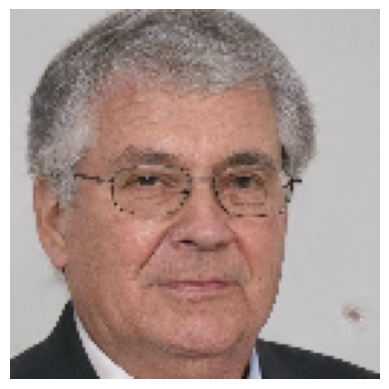

In [ ]:

# 3. Prediction Function
import numpy as np
import matplotlib.pyplot as plt
from keras import config
config.enable_unsafe_deserialization()  # Safe load

try:
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("✅ Model loaded successfully!")
except Exception as e:
    print("⚠️ Model load failed:", e)

def predict_image(image_path):
    try:
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128,128))
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_batch)[0][0]
        label = "REAL" if prediction >= 0.5 else "DEEPFAKE"
        print(f"Prediction: {label}, Score: {prediction:.4f}")
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print("⚠️ Prediction failed:", e)

predict_image('/content/drive/MyDrive/Colab_Projects/CEO.jpg')
